Pearson correlation coefficient: 0.8732750692887103
P-value: 2.3788600613437488e-07


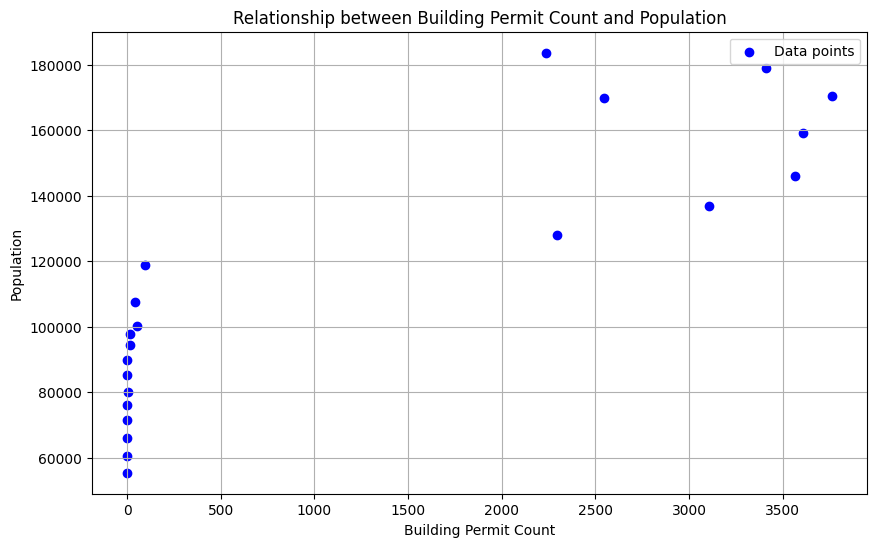

Mean Squared Error: 11690276.596226517
Cross-validated MSE: 102657705.32311292


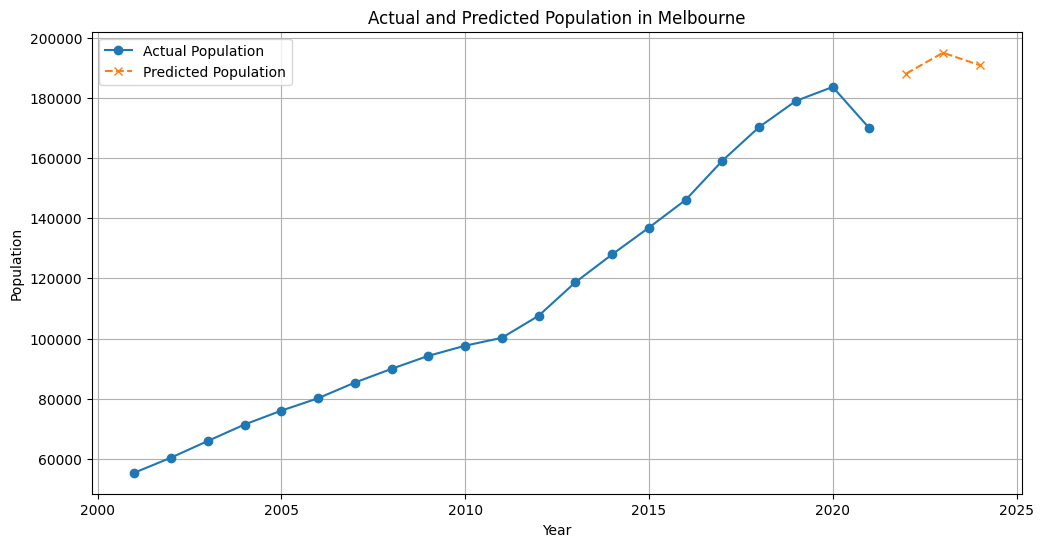

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# Load and preprocess the response dataset
response = pd.read_csv("../data/response/abs_regional_population_lga_2001_2021.csv")
response.columns = response.columns.str.replace(' ', '')
KEY_RESPONSE_COLUMNS = ['lga_name_2021'] + [f"erp_{i}" for i in range(2001, 2022)]
response_clean = pd.DataFrame(response[KEY_RESPONSE_COLUMNS].iloc[7]).reset_index()
response_clean = response_clean.rename(columns={'index': 'year', 7: 'population'})
response_clean = response_clean.iloc[1:]
response_clean['year'] = response_clean['year'].str.removeprefix('erp_').astype(int)

# Load and preprocess the predictor dataset
predictor = pd.read_json("../data/predictor/Building Permits Cleaned.json")
predictor = predictor.drop_duplicates(subset=['permit_number'])
predictor_clean = predictor.groupby('year')['council_ref'].count().reset_index(name='building_permit_count')
predictor_clean = predictor_clean[predictor_clean['year'] > 2000]

# Merge datasets
analysis_df = pd.merge(predictor_clean, response_clean, on='year')
analysis_df['year'] = pd.to_numeric(analysis_df['year'])
analysis_df['building_permit_count'] = pd.to_numeric(analysis_df['building_permit_count'])
analysis_df['population'] = pd.to_numeric(analysis_df['population'])

# Correlation analysis
corr, p_value = pearsonr(analysis_df['building_permit_count'], analysis_df['population'])
print(f"Pearson correlation coefficient: {corr}")
print(f"P-value: {p_value}")

# Plotting the relationship
plt.figure(figsize=(10, 6))
plt.scatter(analysis_df['building_permit_count'], analysis_df['population'], color='blue', label='Data points')
plt.xlabel('Building Permit Count')
plt.ylabel('Population')
plt.title('Relationship between Building Permit Count and Population')
plt.grid(True)
plt.legend()
plt.show()

# Feature engineering
analysis_df['year_squared'] = analysis_df['year'] ** 2

# Split data into train and test sets
X = analysis_df[['year', 'building_permit_count', 'year_squared']]
y = analysis_df['population']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with StandardScaler and Ridge Regression
model = make_pipeline(StandardScaler(), RidgeCV(alphas=np.logspace(-6, 6, 13)))

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validated MSE: {-cv_scores.mean()}")

# Prediction for 2022, 2023, 2024
future_years = pd.DataFrame({
    'year': [2022, 2023, 2024],
    'building_permit_count': predictor_clean[predictor_clean['year'].isin([2022, 2023, 2024])]['building_permit_count'],
    'year_squared': [2022**2, 2023**2, 2024**2]
})
future_years['population'] = model.predict(future_years)

# Plotting the actual and predicted population
plt.figure(figsize=(12, 6))
plt.plot(analysis_df['year'], analysis_df['population'], label='Actual Population', marker='o')
plt.plot(future_years['year'], future_years['population'], label='Predicted Population', marker='x', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Actual and Predicted Population in Melbourne')
plt.legend()
plt.grid(True)
plt.show()
